# 非周末单独

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler

In [26]:
def mape_func(data, target_date, data_index):
    group_data = data.groupby(by='date')
    target_date = data.loc[target_date].index[1]                 #用于mape的时间
    aim_date = target_date + datetime.timedelta(days=1)          #需要预测的时间
    x_pred = data.loc[target_date, 'load'].values.flatten()
    def mapes(x_true,x_pred =x_pred):
        y = x_true['load'].values.flatten()
        x = x_pred
        mape = np.mean(np.abs(x - y)/x)*100
        return mape
       
    mape_data = group_data.apply(mapes)
    #train_index = mape_data[mape_data<10].index
    
    #train_index = train_index[train_index != target_date]        #让预测数据不会进入模型
    vaild_index = np.array([])
    train_index = np.array([])
    for i in mape_data.sort_values()[1:101].index.sort_values():
        a = i + datetime.timedelta(days=1)
        if a in data_index:
            train_index = np.append(train_index, i)
            vaild_index = np.append(vaild_index, a)
        else:
            continue
    return train_index,vaild_index


In [4]:
def reshape_data(index_T, index_V, data):
    sc_hour = MinMaxScaler()
    
    data['hour'] = sc_hour.fit_transform(data['hour'].values.reshape(-1,1))
    sc_temp = MinMaxScaler()
    data['temp'] = sc_temp.fit_transform(data['temp'].values.reshape(-1,1))
    sc_load = MinMaxScaler()
    data['load'] = sc_load.fit_transform(data['load'].values.reshape(-1,1))
    length = int(np.floor(index_T.shape[0]*0.7))
    print(length,'-------------------------------')
    X_train = data.loc[index_T].iloc[:length*48].values.reshape(-1,48,3)      
    y_train = data.loc[index_V].iloc[:length*48, 2].values.reshape(-1,48)    
    X_test = data.loc[index_T].iloc[length*48:].values.reshape(-1,48,3)
    y_test = data.loc[index_V].iloc[length*48:, 2].values.reshape(-1,48)
    
    #X_train, X_test, y_train, y_test = train_test_split(data.loc[index_T], data.loc[index_V, 'load'], test_size=0.3)
    return [X_train, X_test, y_train, y_test,sc_hour, sc_temp, sc_load]


In [27]:
def modle_set():
    #建立LSTM模型 训练
    inputs=tf.keras.layers.Input(shape=(48, 3))
    model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(48)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

In [29]:
def mainSet(data, target_date, aim_data, data_index):   
    data_real = data.copy()                                                                           #未归一化的datarale
    
    train_index,vaild_index = mape_func(data, target_date, data_index)
    a = reshape_data(train_index, vaild_index, data)                                                  #会将data     normolization
    
    model = modle_set()
    model.fit(a[0], a[2], epochs = 30, batch_size = 16,shuffle=False,validation_data=(a[1], a[3]))   #训练模型--专属

    for_pred = data.loc[target_date].values.reshape(1,48,3)                                            #用前一天

    pred_data = model.predict(for_pred)                                                                #预测后一天
    pred_data_true = a[-1].inverse_transform(pred_data.reshape(-1,1)).flatten()
    true_value = data_real.loc[aim_data,'load'].values.flatten()                                       #后一天的真实值 
    
    print(target_date, 'to predict', aim_data)
    
    plt.plot(pred_data_true, 'b')
    plt.plot(true_value,'r')
    plt.show()
    
    print('pred')
    print(pred_data_true)
    print('true')
    print(true_value)
    mapes = np.mean(np.abs(true_value - pred_data_true)/true_value)*100
    print('mape:', mapes)

In [15]:
data = pd.read_csv('unweek.csv', index_col=['date'], parse_dates=['date'])
data

,hour,temp,load,week
date,,,,
2006-01-04,0.0,19.50,7526.44167,3
2006-01-04,0.5,19.35,7340.25500,3
2006-01-04,1.0,19.20,7113.48333,3
2006-01-04,1.5,19.10,6772.77000,3
2006-01-04,2.0,19.00,6490.73167,3
...,...,...,...,...
2010-12-30,21.5,22.70,0.00000,3
2010-12-30,22.0,22.60,0.00000,3
2010-12-30,22.5,22.45,0.00000,3


In [43]:
data_index[0:6]

DatetimeIndex(['2006-01-04', '2006-01-05', '2006-01-09', '2006-01-10',
               '2006-01-11', '2006-01-12'],
              dtype='datetime64[ns]', name='date', freq=None)

55 -------------------------------
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 3)]           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 48, 48)            192       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 48, 48)            2352      
_________________________________________________________________
lstm_30 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_31 (LSTM)               (None, 48, 48)            18624     
_________________________________________________________________
lstm_32 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_10 (Dense)       

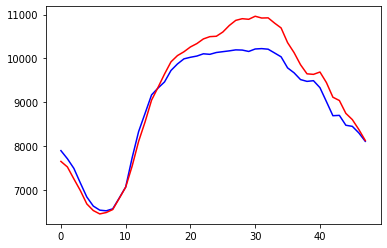

pred
[ 7894.697   7710.171   7489.806   7157.473   6837.192   6630.092
  6536.845   6521.9556  6567.1304  6811.5386  7065.0137  7733.602
  8330.12    8747.5205  9166.815   9322.63    9462.299   9724.061
  9872.776   9988.806  10024.609  10052.667  10103.933  10091.914
 10133.484  10152.365  10170.992  10193.556  10189.016  10157.475
 10213.702  10222.279  10208.96   10122.532  10035.088   9783.06
  9670.631   9515.689   9474.656   9490.474   9331.409   9013.196
  8691.265   8699.4375  8473.898   8448.712   8299.621   8106.978 ]
true
[ 7648.91  7522.9   7250.11  6983.95  6678.93  6527.84  6451.08  6482.67
  6550.38  6803.68  7060.84  7542.92  8107.22  8552.34  9047.38  9338.84
  9642.49  9921.24 10063.48 10150.74 10260.44 10337.52 10443.14 10495.48
 10503.94 10600.22 10749.57 10866.81 10904.73 10891.05 10960.73 10920.08
 10923.9  10803.46 10693.98 10359.21 10131.65  9854.9   9647.02  9634.84
  9688.24  9447.12  9113.39  9038.3   8744.73  8602.71  8377.93  8126.06]
mape: 3.14038491554418

In [31]:
data = pd.read_csv('unweek.csv', index_col=['date'], parse_dates=['date'])
del data['week']
data_index = data.index.unique()
mainSet(data, '2010-12-14', '2010-12-15', data_index)